In [3]:
import os
from os import path

import pandas as pd
import numpy as np
import seaborn as sns #Seaborn for pretty heatmap :D
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
import matplotlib.pyplot as plt

#Models tested.
import sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
#Need to enable experimental to use hist gradient boosting
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

#Librosa lib.
import librosa
import librosa.display

#Preprocessing / preformance metrics.
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
from sklearn import preprocessing
#import pickle
#import itertools

#Custom files.
from data_preprocessing import *
from data_analysis import *
from helpers import *

fileName = "features.dat"

data = load_binaryfile(fileName)

print("done loading")
data.head()

done loading


,classlabel,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,bandwidth_mean,bandwidth_var,centroid_mean,centroid_var,zero_crossing_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,blues,0.335434,0.091088,0.130405,0.003521,1972.723622,117298.851326,1773.285877,168244.728448,0.081851,...,1.877616,2353.939941,1.576506,2219.069580,1.529033,2097.942871,1.183121,1991.447388,1.112082,1894.162476
1,blues,0.343020,0.086142,0.112699,0.001450,2009.201575,65548.531475,1816.195860,90703.325185,0.087173,...,2.379336,2452.845947,1.880546,2314.937988,1.788251,2189.285645,1.542793,2080.248535,1.755690,1980.097534
2,blues,0.346838,0.092210,0.132002,0.004620,2085.045996,74755.260660,1788.642783,111322.537051,0.071383,...,3.097872,2507.301514,2.809684,2362.796631,2.781829,2234.215820,2.533761,2120.529053,2.533194,2016.159058
3,blues,0.363671,0.086856,0.132562,0.002447,1959.202709,83672.222326,1654.902168,112316.264385,0.069426,...,2.298341,2454.086670,1.936131,2313.473877,1.898311,2186.921631,1.607881,2076.045410,1.709453,1974.035522
4,blues,0.335927,0.088291,0.143289,0.001701,1948.459295,60221.595017,1630.737017,79648.228297,0.070102,...,3.648756,2288.108154,3.471156,2156.658691,3.373302,2039.879761,3.016701,1936.210938,2.893213,1841.151001


In [4]:
y = data.classlabel
X = data.drop('classlabel',axis=1)

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = accuracy_score(y_test, preds) * 100 #* 100 for procent
    print(f'Accuracy {title} : {score:4.3f}%\n')

In [4]:
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

sgd = SGDClassifier()
model_assess(sgd, "Stochastic Gradient Descent")

knn = KNeighborsClassifier()
model_assess(knn, "KNN")

tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

rforest = RandomForestClassifier()
model_assess(rforest, "Random Forest")

svm = SVC()
model_assess(svm, "Support Vector Machine")

lg = LogisticRegression()
model_assess(lg, "Logistic Regression")

nn = MLPClassifier()
model_assess(nn, "Neural Nets")

grad = GradientBoostingClassifier()
model_assess(grad,"Gradient boost")

#Hist klart bedste score - men experimental, så på nuværende ikke "fremtids sikker"
hist = HistGradientBoostingClassifier()
model_assess(hist,"Hist gradient boost")

xgb = XGBClassifier()
model_assess(xgb, "Cross Gradient Booster")

Accuracy Naive Bayes : 38.539%

Accuracy Stochastic Gradient Descent : 49.082%

Accuracy KNN : 78.345%

Accuracy Decission trees : 66.166%

Accuracy Random Forest : 83.350%

Accuracy Support Vector Machine : 59.393%



C:\Users\jonas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Logistic Regression : 57.357%



C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy Neural Nets : 66.233%

Accuracy Gradient boost : 78.045%

Accuracy Hist gradient boost : 87.654%

Accuracy Cross Gradient Booster : 86.720%



In [11]:
from sklearn.model_selection import GridSearchCV

model = XGBClassifier()

params = [{
    'eta':[1e-5,1e-3,1e-1,1],
    'max_depth':[5,10,20,40,100],
    'subsample':[0.5,1],
    'sampling_method':['uniform'],
    'tree_method':['exact','approx','hist'],
    'grow_policy':['depthwise','lossguide']
}]
#Findes flere sampling måder - men virker kun GPU based
#subsample < 1, skulle gerne skal tjek for overfitting.
#Eta = learning rate.

grid_tuned = GridSearchCV(estimator=model,
                         param_grid=params,
                         cv=5,
                         scoring='accuracy',
                         verbose=False,
                         iid=True,
                         n_jobs=-1)

grid_tuned.fit(X_train,y_train)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_job...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
  

In [122]:
print("best params:",grid_tuned.best_params_)
print("best score:",grid_tuned.best_score_)

best params: {'eta': 0.1, 'grow_policy': 'depthwise', 'max_depth': 10, 'sampling_method': 'uniform', 'subsample': 1, 'tree_method': 'approx'}
best score: 0.8376948376948377


In [6]:
from sklearn.model_selection import RandomizedSearchCV

model = XGBClassifier()

params = [{
    'eta':[1e-5,1e-3,1e-1,1],
    'max_depth':[5,10,20,40,100],
    'subsample':[0.5,1],
    'sampling_method':['uniform'],
    'tree_method':['exact','approx','hist'],
    'grow_policy':['depthwise','lossguide']
}]

Grid_tune = RandomizedSearchCV(estimator=model,param_distributions=params,scoring='accuracy',
                              random_state=42,n_jobs=-1)

Grid_tune.fit(X_train,y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=Non

In [42]:
print("best params:",Grid_tune.best_params_)
print("best score:",Grid_tune.best_score_)

best params: {'tree_method': 'approx', 'subsample': 1, 'sampling_method': 'uniform', 'max_depth': 40, 'grow_policy': 'lossguide', 'eta': 0.1}
best score: 0.8272555197305248
4022    False
5412    False
487     False
39      False
6795    False
        ...  
1579    False
7905     True
6113    False
3532    False
409     False
Name: classlabel, Length: 2997, dtype: bool


In [9]:
#best model / gridsearch
eval_set = [(X_test,y_test)]
model = XGBClassifier(eta = 0.1,
                      grow_policy = 'depthwise',
                      max_depth = 10,
                      sampling_method = 'uniform',
                      subsample = 1,
                      tree_method = 'approx'
                     )
#Random search
model2 = XGBClassifier(eta = 0.1,
                      tree_method='approx',
                      subsample=1,
                      sampling_method='uniform',
                      max_depth=40,
                      grow_policy='lossguide'
                      )

model.fit(X_train,y_train,early_stopping_rounds=10,eval_metric="merror",eval_set=eval_set,verbose=False)
model2.fit(X_train,y_train,early_stopping_rounds=10,eval_metric="merror",eval_set=eval_set,verbose=False)

results = model.evals_result()
results2 = model2.evals_result()
print(f'Model1: {results} \n Model2: {results2}')

Model1: {'validation_0': {'merror': [0.315315, 0.281281, 0.261595, 0.247581, 0.235235, 0.230564, 0.223223, 0.219219, 0.214548, 0.210878, 0.209543, 0.207875, 0.204538, 0.201535, 0.201869, 0.199533, 0.197197, 0.193193, 0.193527, 0.189857, 0.190858, 0.188522, 0.188522, 0.187187, 0.18652, 0.181181, 0.182182, 0.179847, 0.179179, 0.177845, 0.175843, 0.175175, 0.174842, 0.174842, 0.173841, 0.171171, 0.172172, 0.170504, 0.169837, 0.169503, 0.169169, 0.166166, 0.1665, 0.165833, 0.166166, 0.1665, 0.164498, 0.163831, 0.161161, 0.160494, 0.159826, 0.158492, 0.159159, 0.156823, 0.155489, 0.154821, 0.155155, 0.153153, 0.153153, 0.154154, 0.154154, 0.15382, 0.15382, 0.154154, 0.152152, 0.152486, 0.153487, 0.152486, 0.151151, 0.151485, 0.150484, 0.150817, 0.148815, 0.147814, 0.147814, 0.147147, 0.147147, 0.14648, 0.146813, 0.145145, 0.145145, 0.145145, 0.144811, 0.144478, 0.145145, 0.144478, 0.14381, 0.142809, 0.144811, 0.14381, 0.143143, 0.142809, 0.142809, 0.143477, 0.144144, 0.143477, 0.142476, 0.1

In [32]:
from sklearn.metrics import precision_score, recall_score
#Der bruges macro da alle klasser anses for værende lige - 100 sange pr klasse.

preds1 = model.predict(X_test)

Acc_score = accuracy_score(y_test, preds1) * 100 #* 100 for procent
recall1 = recall_score(y_test,preds1,average='macro') * 100
precision1 = precision_score(y_test,preds1,average='macro') * 100

print(f'Model 1 Accuracy:{Acc_score:.3f}%   Recall:{recall1:.3f}%   Precision:{precision1:.3f}% \n')

preds2 =model2.predict(X_test)

Acc_score2 = accuracy_score(y_test,preds2) * 100
recall2 = recall_score(y_test,preds2,average='macro') * 100
precision2 = precision_score(y_test,preds2,average='macro') * 100

print(f'Model 2 Accuracy:{Acc_score2:.3f}%   Recall:{recall2:.3f}%   Precision:{precision2:.3f}% \n')

Model 1 Accuracy:85.853%   Recall:85.851%   Precision:86.076% 

Model 2 Accuracy:85.219%   Recall:85.228%   Precision:85.325% 



In [ ]:
# Confusion matrix

conf_m = confusion_matrix(y_test,preds)
print(conf_m)

plt.figure(figsize = (16,16))
labels = ["blues", "classical", "country", "disco","hiphop", "jazz", "metal", "pop", "reggae", "rock"] 
sns.heatmap(conf_m,annot=True,cmap='OrRd',xticklabels=labels,yticklabels=labels)

In [23]:
from data_preprocessing import get_features

def make_predict(pathtofile):
    to_test = get_features(pathtofile)
    to_test = to_test.drop('classlabel',axis=1)
    pred = model.predict(to_test)
    print(pred)

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/rock/rock.00042.wav"
make_predict(path)

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/pop/pop.00001.wav"
make_predict(path)

path = "C:/Users/jonas/AU/s5/MAL/opgaver/Data/genres_original/reggae/reggae.00060.wav"
make_predict(path)

['rock']
['pop']
['classical']


In [66]:
csvdata = pd.read_csv('C:/Users/jonas/AU/s5/MAL/opgaver/Data/features_3_sec.csv')

csvdata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [67]:
csvdata = csvdata.iloc[0:, 1:]
y = csvdata['label']
X = csvdata.loc[:, csvdata.columns != 'label']

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

eval_set = [(X_test,y_test)]
model = XGBClassifier(eta = 0.1,
                      grow_policy = 'depthwise',max_depth = 10,
                      sampling_method = 'uniform',
                      subsample = 1,
                      tree_method = 'approx'
                     )

model.fit(X_train,y_train,early_stopping_rounds=10,eval_metric="merror",eval_set=eval_set,verbose=True)

preds = model.predict(X_test)
Acc_score = accuracy_score(y_test, preds) * 100 #* 100 for procent
F1 = f1_score(y_test,preds,average='micro') * 100
print(f'Accuracy : {Acc_score:.3f}%\n')

[0]	validation_0-merror:0.32799
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.27361
[2]	validation_0-merror:0.24858
[3]	validation_0-merror:0.23223
[4]	validation_0-merror:0.22289
[5]	validation_0-merror:0.21321
[6]	validation_0-merror:0.20520
[7]	validation_0-merror:0.19419
[8]	validation_0-merror:0.19286
[9]	validation_0-merror:0.18518
[10]	validation_0-merror:0.18585
[11]	validation_0-merror:0.18352
[12]	validation_0-merror:0.17918
[13]	validation_0-merror:0.17885
[14]	validation_0-merror:0.17684
[15]	validation_0-merror:0.17217
[16]	validation_0-merror:0.17017
[17]	validation_0-merror:0.17084
[18]	validation_0-merror:0.17017
[19]	validation_0-merror:0.16817
[20]	validation_0-merror:0.16750
[21]	validation_0-merror:0.16517
[22]	validation_0-merror:0.16049
[23]	validation_0-merror:0.16250
[24]	validation_0-merror:0.16216
[25]	validation_0-merror:0.16016
[26]	validation_0-merror:0.15816
[27]	validation_0-merror:0.15749
[28]	validation_0-m

In [33]:
preds = model.predict(X_test)
Acc_score = accuracy_score(y_test, preds) * 100 #* 100 for procent
F1 = f1_score(y_test,preds,average='micro') * 100
print(f'Accuracy : {Acc_score:.3f}%\n')

Accuracy : 88.789%



[[268   1  20   7   1   8   5   0   7   2]
 [  0 298   0   0   0   8   0   0   0   2]
 [ 14   1 245   3   0  14   0   3   3   3]
 [  1   3   6 263   3   1   1  10   2  11]
 [  5   1   5   4 276   3   5   7   2   3]
 [  6  13   9   1   0 253   0   1   2   1]
 [  2   0   2   2   4   1 283   0   3   6]
 [  0   0   5   1   1   1   0 256   0   3]
 [  1   2  10   5   6   3   2   6 278   3]
 [  7   2  13  17   2   4   7   2   5 241]]


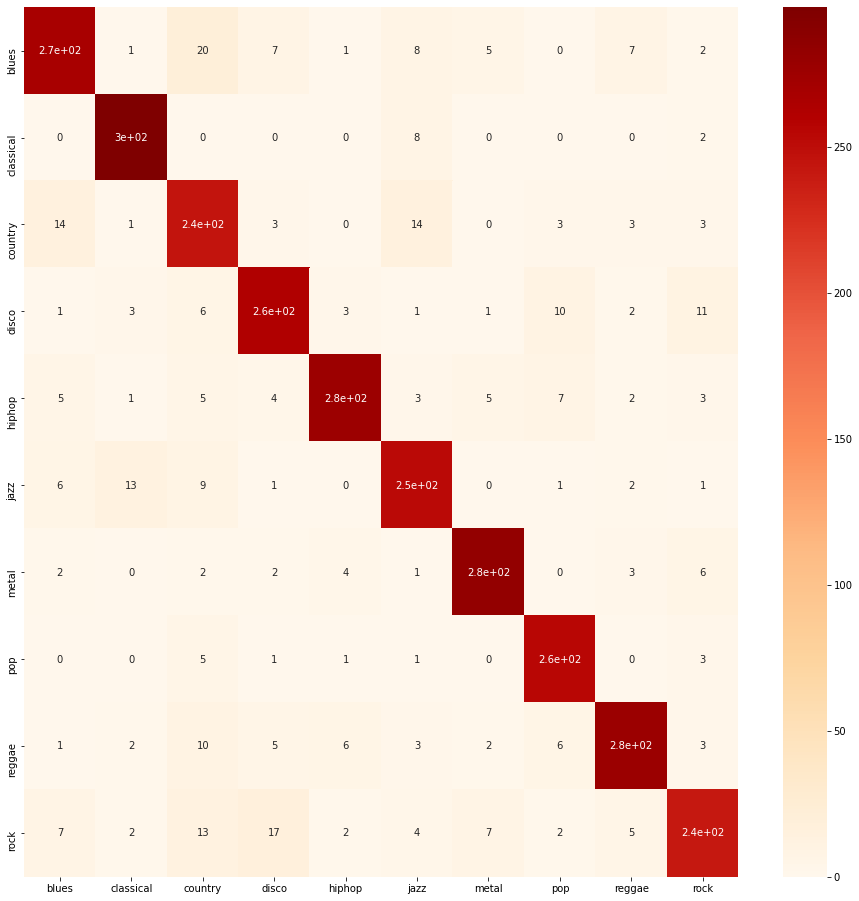

In [34]:
conf_m = confusion_matrix(y_test,preds)
print(conf_m)

plt.figure(figsize = (16,16))
labels = ["blues", "classical", "country", "disco","hiphop", "jazz", "metal", "pop", "reggae", "rock"] 
sns.heatmap(conf_m,annot=True,cmap='OrRd',xticklabels=labels,yticklabels=labels)